#### TOC
1. Anomalies in Data, and cleaning action & explaination. 15 pts
2. Pairwise Corralation Table and explaition. 10 pts
3. Average records stockID vs Day, 25 pts
    - a. autocorrelation, 10 pts
    - b. measure the distance, 5 pts
    - c. clustering algorithm, 10 pts
4. Closing trajectory of stocks on each day highly correlated, 25 pts
   - a. Make three plots, 10 pts
   - b. permutation test to determine the statistical confidence, 15 pts
      p-value
5. Best prediction model, any approaches, 25 pts
6. submit model on Kaggle, 0 pts

#### Start
- Copy this notebook.
  In Google Colab use `File -> Save a Copy in Drive`.
- Use the "Text" blocks to provide explanations wherever you find them necessary.
- Highlight your answers inside these text fields to ensure that we don't miss it
while grading your HW.

#### Setup

- Code to download the data directly from the colab notebook.
- If you find it easier to download the data from the kaggle website (and
uploading it to your drive), you can skip this section.

In [1]:
## First mount your drive before running analysis code
from google.colab import drive
drive.mount('/content/drive')

## Create a folder for the this HW and change to that dir
%cd drive/MyDrive/cse519


Mounted at /content/drive
/content/drive/MyDrive/cse519


In [3]:
## packages
!pip install -q kaggle
!pip install -q pandas
!pip install -q scikit-learn
!pip install -q numpy
!pip install -q Matplotlib
!pip install -q seaborn


In [4]:
## Upload the file by clicking on the browse
from google.colab import files
files.upload()

## Create a new API token under "Account" in the kaggle webpage and download the json file

In [5]:
# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !kaggle competitions download -c optiver-trading-at-the-close
# !unzip optiver-trading-at-the-close.zip
!ls

 cse519_hw3_segireddy_rutwik_115936140.ipynb   optiver2023
 example_test_files			       optiver-trading-at-the-close.zip
'kaggle (1).json'			       public_timeseries_testing_util.py
 kaggle.json				       train.csv


#### Q1: Anomalies and Cleaning, 15 pts


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

col_names = [
  "stock_id",
  "date_id",
  "seconds_in_bucket",
  "imbalance_size",
  "imbalance_buy_sell_flag",
  "reference_price",
  "matched_size",
  "far_price",
  "near_price",
  "bid_price",
  "bid_size",
  "ask_price",
  "ask_size",
  "wap",
  "target",
  "time_id",
  "row_id"
]
dtypes = {
  "stock_id": np.int,
  "date_id":np.int,
  "seconds_in_bucket":np.int,
  "imbalance_size":np.float64,
  "imbalance_buy_sell_flag":np.int,
  "reference_price":np.float64,
  "matched_size":np.float64,
  "far_price":np.float64,
  "near_price":np.float64,
  "bid_price":np.float64,
  "bid_size":np.float64,
  "ask_price":np.float64,
  "ask_size":np.float64,
  "wap":np.float64,
  "target":np.float64,
  "time_id":np.int,
  "row_id": "string",
}
csv = pd.read_csv("train.csv")


## Dataset Analysis
- 200 unique stocks
- [0, 480] is the range of dates
- Closing Auction Time Range is divided into buckets of 10 seconds from 0 to 540
- 55% of the far price and near price values are NULL
- 88 values in the target column are NULL


In [ ]:
print("------------Metrics-----------\n")
print(f"Stocks Count: {len(csv['stock_id'].unique())}")
print(f"Date ID Range: {csv['date_id'].min()}, {csv['date_id'].max()}")
print(f"Closing Auction Time Range: {csv['seconds_in_bucket'].min()}, {csv['seconds_in_bucket'].max()} \n\tList of values {csv['seconds_in_bucket'].unique()}")
# print(f"Stocks Count: {csv['imbalance_buy_sell_flag'].unique()}")
print(f"Percentage of null values in Far Price: {csv['far_price'].isna().sum() * 100 / len(csv['far_price'])}")
print(f"Percentage of null values in Near Price: {csv['near_price'].isna().sum() * 100 / len(csv['near_price'])}")
print(f"Number of null values in Target Price: {csv['target'].isna().sum()} out of {len(csv['target'])}")
csv

In [ ]:
print("-------------Data after pre-processing---------------\n")
cleaned_csv = csv.dropna(subset=['target'])
print(f"Number of null values in Target Price: {csv['target'].isna().sum()} out of {len(csv['target'])}")
cleaned_csv

## Results:
- Removed the rows having NULL values in the target column since these rows are meant to be predicted, it doesn't make sense to have them in the dataset.
- About 50% of the Far and Near Price values are NULL because NASDAQ releases the data for these values at 3:55 pm. This leaves a 5-minute time interval where there is no information available for these values.

#### Q2: Pairwise Corralation Table and Explaition. 10 pts


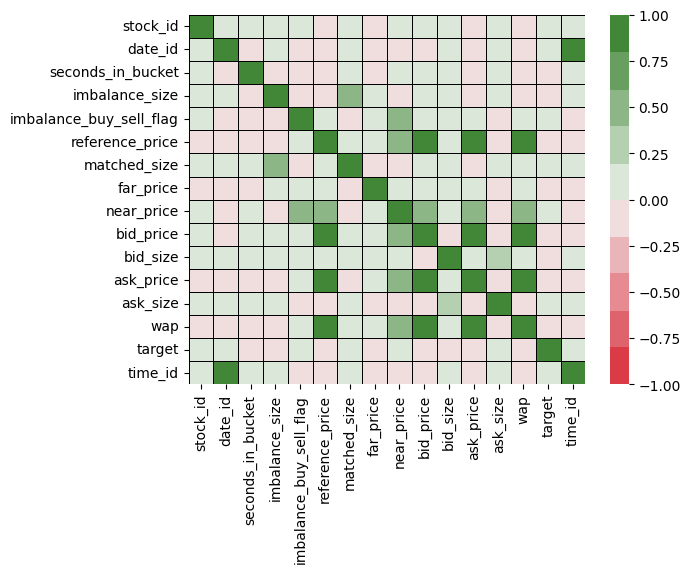

In [5]:
correlation_table = cleaned_csv.corr(method='pearson', numeric_only=True)
ax = sns.heatmap(correlation_table, vmin=-1, vmax=1, center=0,
                 cmap=sns.diverging_palette(10, 125, n=10), linewidths=0.5,
                 linecolor='black')
plt.show()

## Results
- I have constructed a correlation table that takes values from -1 to 1 using Pearson correlation.
- Following is the list of features that are highly correlated (correlation>0.8)
  - date_id and time_id
  - reference_price and bid_price
  - reference_price and ask_price
  - reference_price and wap
  - bid_price and ask_price
  - bid_price and wap
  - ask_price and wap
- This effectiveley means that (date_id, time_id) and (reference_price, bid_price, ask_price, wap) are strongly correlated.
- We find out that time_id = (date_id * 55) + (seconds_in_bucket / 10) which naturally means that date_id and time_id are highly correlated.
- The line plot for (reference_price, bid_price, ask_price, wap) is generated to provide evidence for the high correlation. Given that each of these values is directly or indirectly connected in the stock market realm, it is expected that they would exhibit a strong correlation.

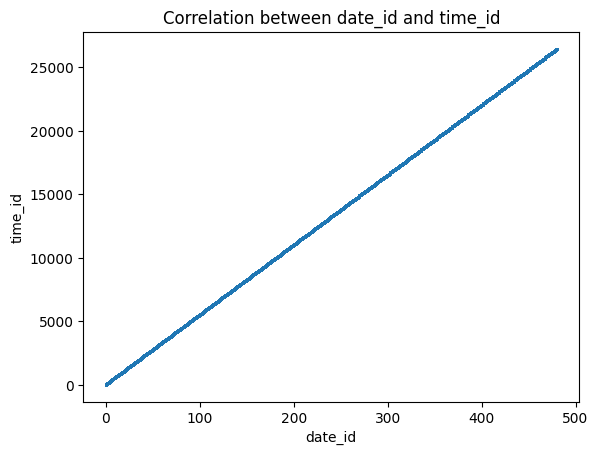

,date_id,seconds_in_bucket,time_id
0,0,0,0
191,0,10,1
382,0,20,2
573,0,30,3
764,0,40,4
...,...,...,...
5236980,480,500,26450
5237180,480,510,26451
5237380,480,520,26452
5237580,480,530,26453


In [6]:
# Correlation betwreen date_id and time_id

# Scatter plot between date_id and time_id
plt.scatter(cleaned_csv['date_id'], cleaned_csv['time_id'], s=0.1)
plt.xlabel('date_id')
plt.ylabel('time_id')
plt.title('Correlation between date_id and time_id')
plt.show()

# Find out the relationship between date_id and time_id
# time_id = (date_id * 55) + (seconds_in_bucket / 10)
stock0 = cleaned_csv[cleaned_csv['stock_id'] == 0]
stock0_date0_480 = stock0[stock0['date_id'].isin([0, 480])]
stock0_date0_480[['date_id', 'seconds_in_bucket', 'time_id']]

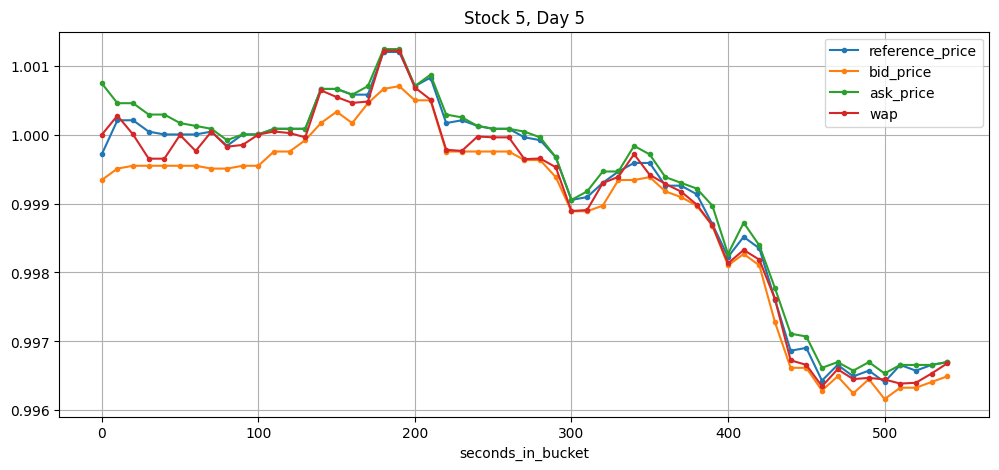

In [7]:
# Correlation between reference_price, bid_price, ask_price and wap

cols=['seconds_in_bucket', 'reference_price', 'bid_price','ask_price', 'wap']
stock_id = 5
date_id = 5

# Line Plot showing the high correlation between these values
stock_day_cols = cleaned_csv[(cleaned_csv['stock_id'] == stock_id) & (cleaned_csv['date_id'] == date_id)][cols]
stock_day_cols.set_index('seconds_in_bucket').plot(title=f"Stock {stock_id}, Day {date_id}", figsize=(12, 5), grid=True, style='.-')
plt.show()

#### Q3: Average records stockID vs Day, 25 pts
distance function between entries
- a. autocorrelation, 10 pts
- b. measure the distance, 5 pts
- c. clustering algorithm, 10 pts



## Observations and Action Performed:
- I'm Defining a consensus record for each stock id s on a particular day d by taking the average of the reference price values.
- I considered taking the the most recent value of the reference price for each day d as a hypothesis could be that the stock prices should have correlation with its immediate values instead of values 2-5 min ago.
- Since the above hypothesis is quite extremely, a good middle ground would be to use a weighted average since the recent values would contribute more to the current stock price than the older values.

In [8]:
consensus_csv = cleaned_csv.groupby(['stock_id', 'date_id'])['reference_price'].mean()
consensus_csv[481: 483]

stock_id  date_id
1         0          0.999645
          1          1.000239
Name: reference_price, dtype: float64

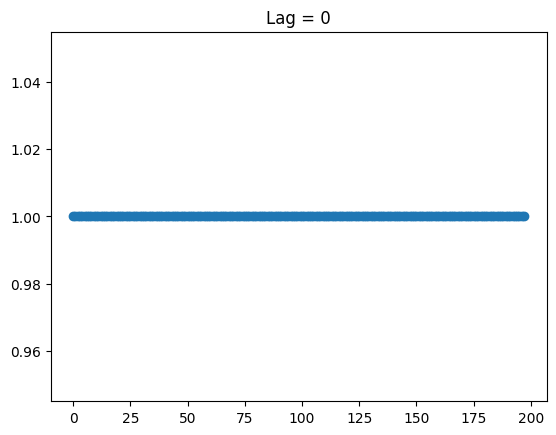

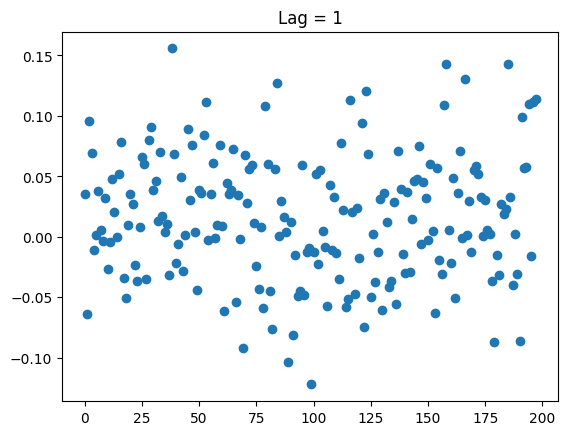

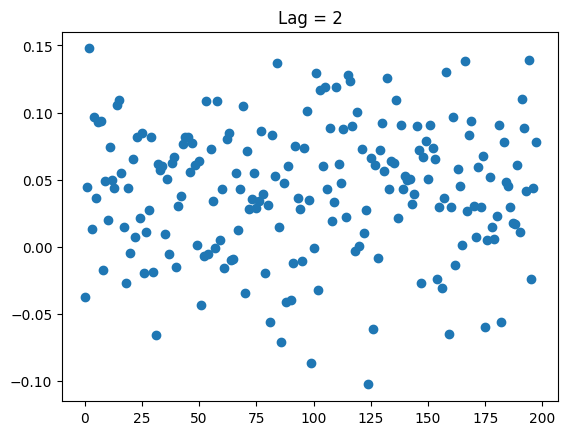

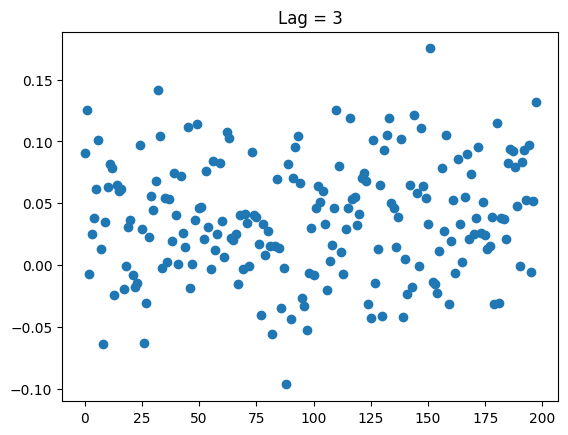

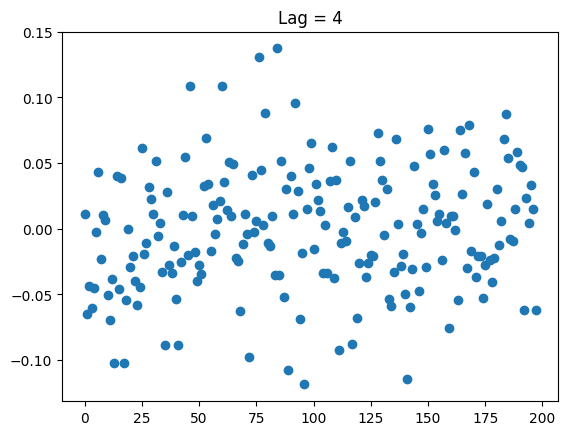

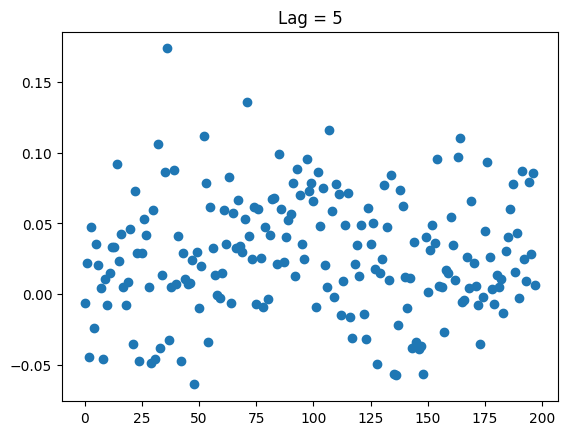

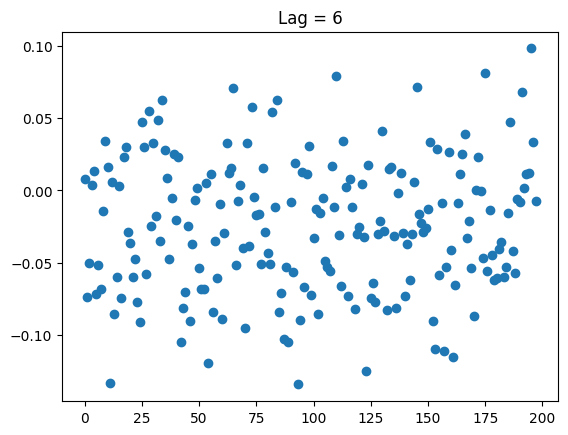

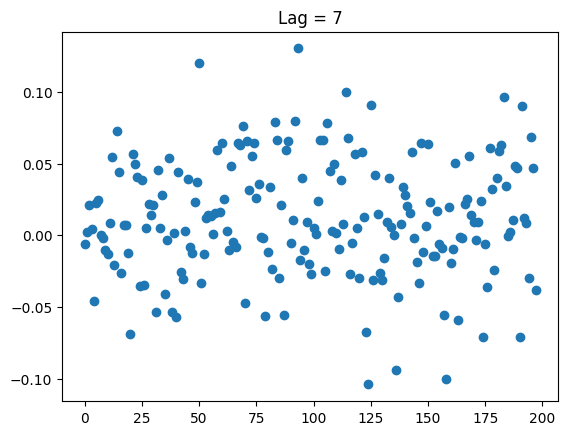

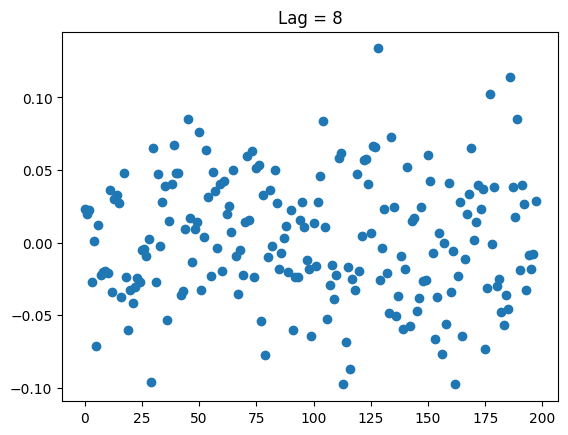

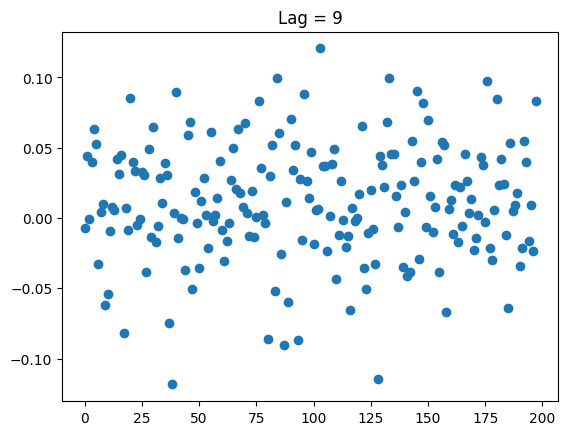

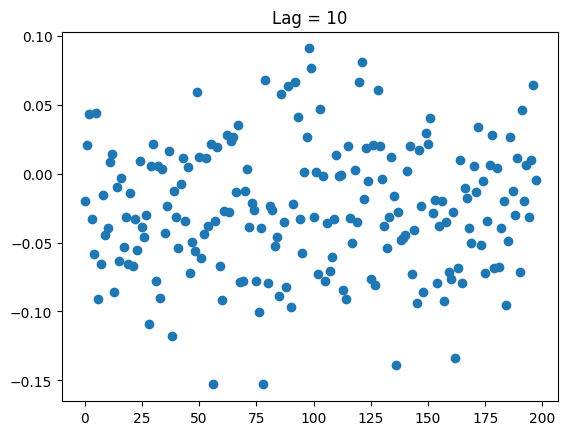

In [11]:
for k in range(11):
  for i in range(200):
    s = consensus_csv[481 * i: 481 * (i + 1)].autocorr(lag=k)
    # print(s)
    plt.scatter(i, s, c='C0')
    plt.title(f"Lag = {k}")
  plt.show()

## Observations and Actions Taken:
- Distance function between prices used is Euclidiean distance.
- Other possible distance functions are mean absolute error.
- One point to note is that I have scaled the distances by 1000 since the prices are in the 1/1000.
- There is almost no difference for Euclidean and Mean Absolute Error.

- Computed the pairwise distances

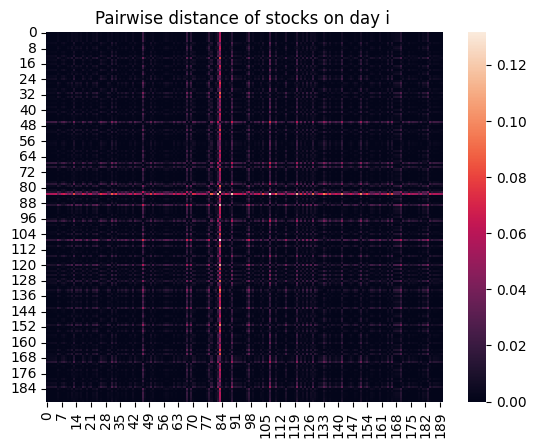

In [51]:
# from scipy.spatial.distance import pdist
from sklearn.metrics import pairwise_distances

def custom_calc(x,y):
    return 1000 * (y-x) ** 2

a = consensus_csv[consensus_csv.index.get_level_values('date_id') == 0]
matrix = pairwise_distances(a.values.reshape(-1,1), metric=custom_calc)

# matrix
# plt.imshow(matrix)
# plt.show()
sns.heatmap(matrix)
plt.title('Pairwise distance of stocks on day i ')
plt.show()

# a = consensus_csv[consensus_csv.index.get_level_values('date_id') == 1]
# matrix = pairwise_distances(a.values.reshape(-1,1), metric=custom_calc)
# sns.heatmap(matrix)
# plt.show()
# pdist(consensus_csv[consensus_csv.index.get_level_values('date_id') == 0], 'euclidean')

In [14]:
# Computing the Mean of Reference Price and WAP for each stock_id
consensus_csv2 = cleaned_csv.groupby(['stock_id'])[['reference_price', 'wap']].mean()
consensus_csv2

,reference_price,wap
stock_id,,
0,0.999835,0.999842
1,0.999926,0.999929
2,1.000149,1.000145
3,0.999978,0.999977
4,0.999859,0.999863
...,...,...
195,0.999915,0.999918
196,1.000072,1.000075
197,1.000051,1.000060


In [52]:
X = cleaned_csv.groupby(['stock_id'])[['reference_price', 'wap']].mean()
# X.values

## Observations and Actions Taken:
- Average is used to define the consensus for each stock.
- Initial cluster means are sampled randomly and is tested for 2 to 5 stocks.
- TSNE plot is given below whereby each cluster is colored differently.
- The clusters are visually coherent to some extent but won't be able to have high confidence.


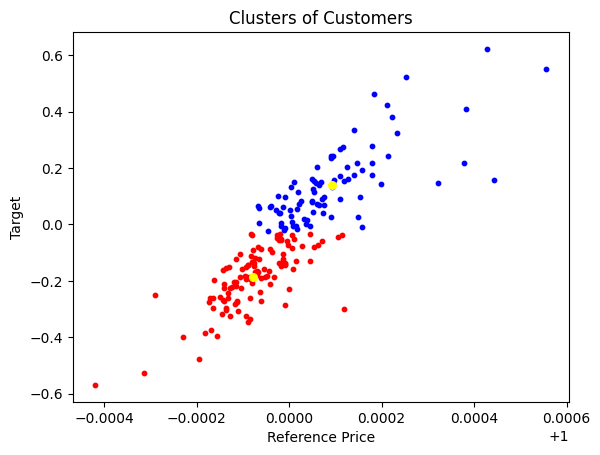

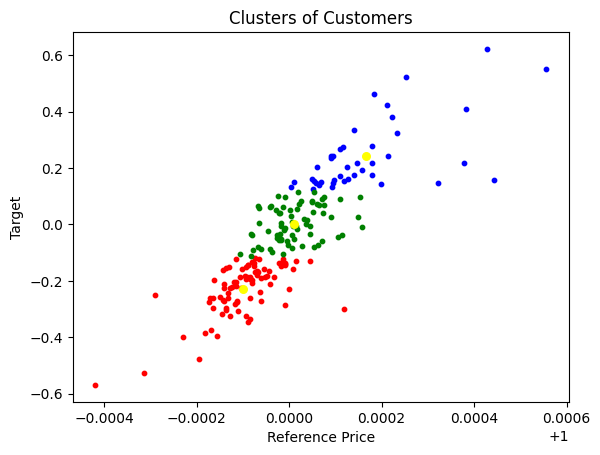

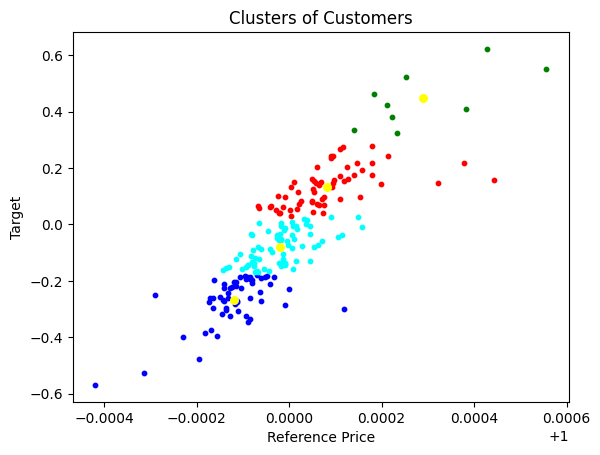

In [16]:
from sklearn.cluster import KMeans

X = cleaned_csv.groupby(['stock_id'])[['reference_price', 'target']].mean().values

num_clusters = range(2, 5)

for c in num_clusters:
  kmeans = KMeans(n_clusters=c, n_init=10, init ='k-means++', max_iter=300, random_state=0)

  y_kmeans = kmeans.fit_predict(X)

  # X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(X)

  plt.scatter(X[y_kmeans==0, 0], X[y_kmeans==0, 1], s=10, c='red', label ='Cluster 1')
  plt.scatter(X[y_kmeans==1, 0], X[y_kmeans==1, 1], s=10, c='blue', label ='Cluster 2')
  plt.scatter(X[y_kmeans==2, 0], X[y_kmeans==2, 1], s=10, c='green', label ='Cluster 3')
  plt.scatter(X[y_kmeans==3, 0], X[y_kmeans==3, 1], s=10, c='cyan', label ='Cluster 4')
  plt.scatter(X[y_kmeans==4, 0], X[y_kmeans==4, 1], s=10, c='magenta', label ='Cluster 5')

  plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=30, c='yellow', label = 'Centroids')
  plt.title('Clusters of Customers')
  plt.xlabel('Reference Price')
  plt.ylabel('Target')
  plt.show()

#### Q4: Closing trajectory of stocks on each day highly correlated, 25 pts


- a. Make three plots, 10 pts
- b. permutation test for statistical confidence, p-value, 15 pts


## Observations and Actions Taken:-
---
- 3 plots are listed below that
- 1st Plot shows that in the initial seconds in bucket, the imbalance size has higher values and then lower towards the end of the day. This is an important indication showing that markets tend to have more fluctuations in the morning and tend to get stable towards the day's close.
- 2nd Plot shows the distribution of the reference_price which has an average of around 1. There is no correlation between positive and negative changes.

In [40]:
def scatter_plot(df, x_colname, y_colname, figscale=1, alpha=.8):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(6 * figscale, 6 * figscale))
  df.plot(kind='scatter', x=x_colname, y=y_colname, s=(32 * figscale), alpha=alpha)
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plot(cleaned_csv, *['seconds_in_bucket', 'imbalance_size'], **{})
chart

<Figure size 600x600 with 0 Axes>

In [ ]:
# Function to calculate number of bins in a histrogram
def calc_num_bins(x):
  q25, q75 = np.percentile(x, [25, 75])
  bin_width = 2 * (q75 - q25) * len(x) ** (-1/3)
  bins = round((x.max() - x.min()) / bin_width)
  print("Freedman–Diaconis number of bins:", bins)
  return bins

In [58]:
import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=50, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart1 = histogram(cleaned_csv, *['reference_price'], **{})
chart1

## Observations and Actions Taken:-
-

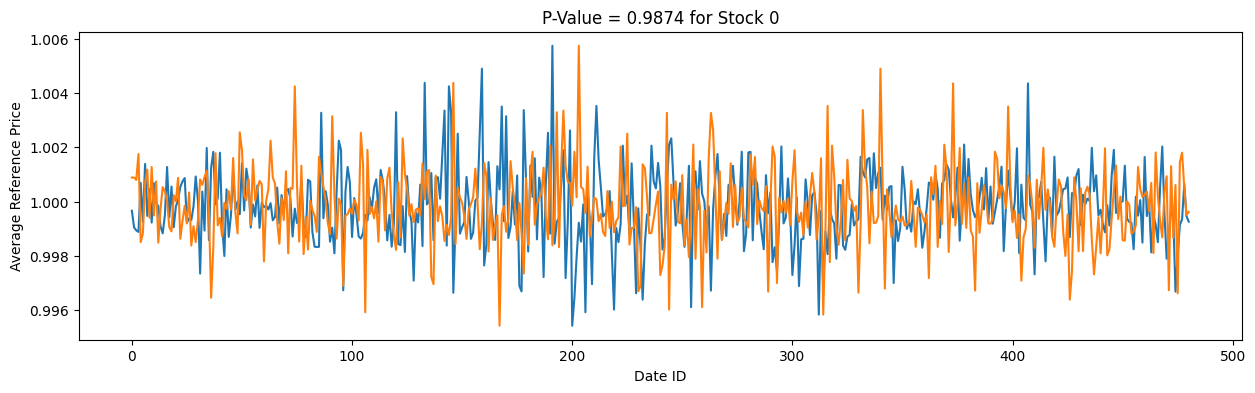

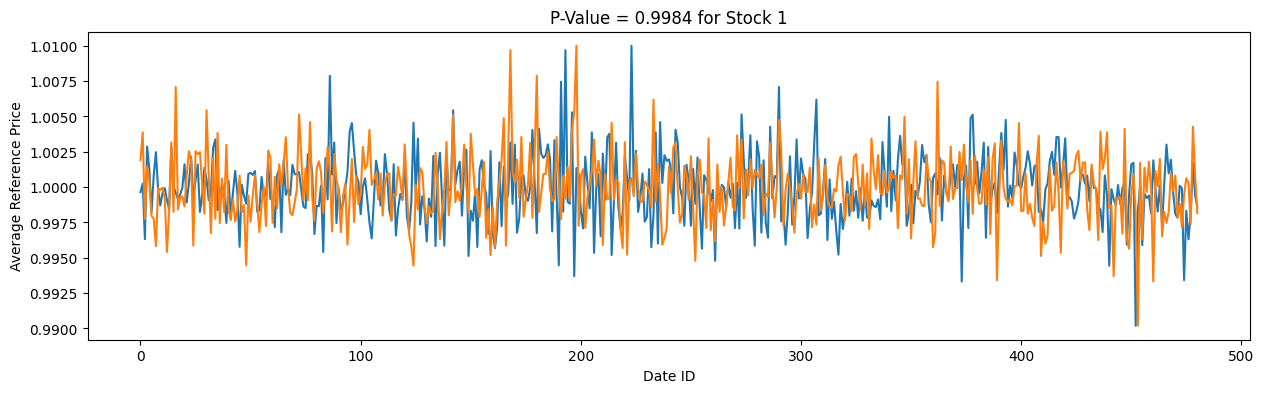

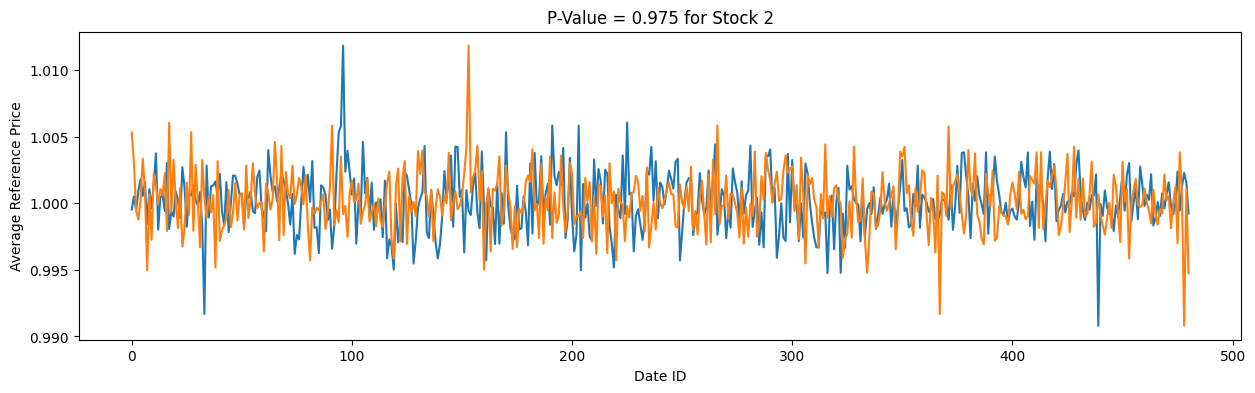

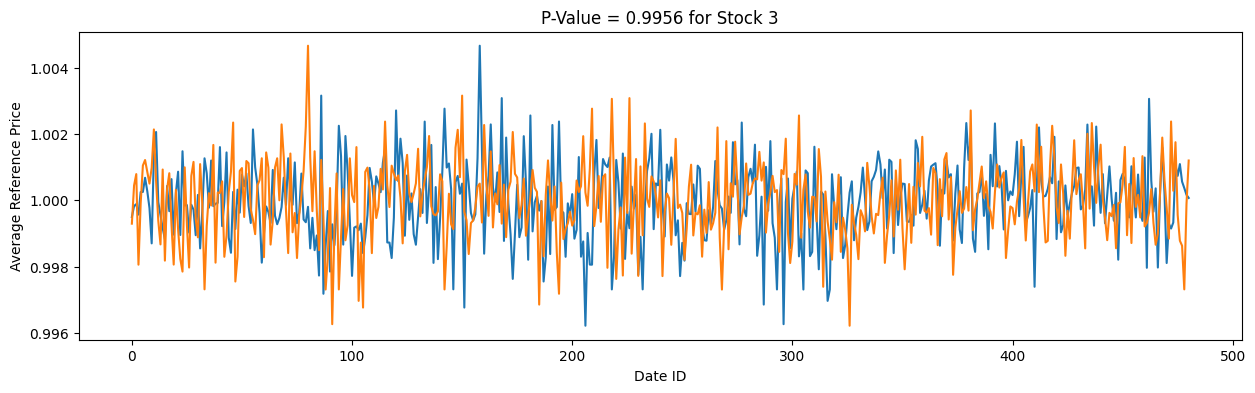

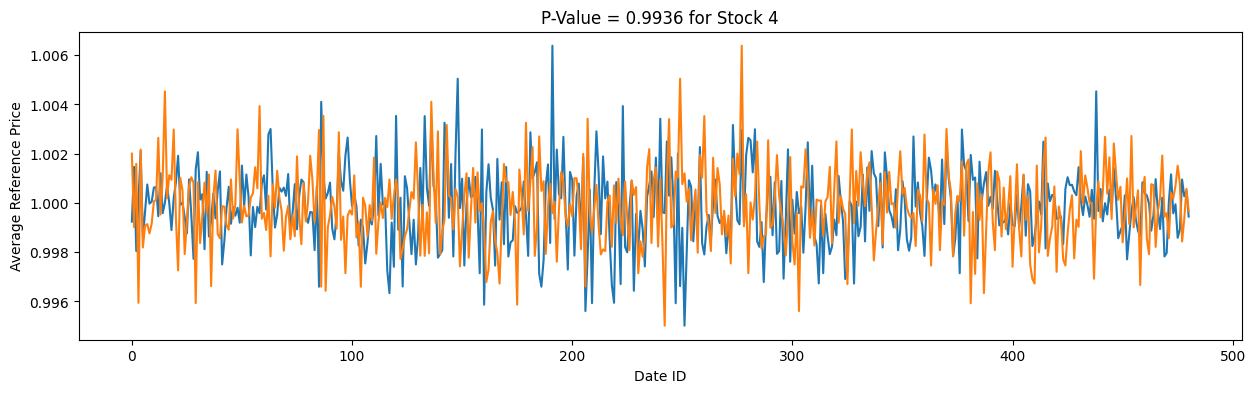

In [17]:
from scipy.stats import permutation_test
import random
import copy

def statistic(x, y, axis):
  return np.mean(x, axis=axis) - np.mean(y, axis=axis)

for s in range(0, 5):
  con_csv_stock_0 = consensus_csv[consensus_csv.index.get_level_values('stock_id') == s].to_numpy()
  plt.figure(figsize=(15,4))
  plt.plot(range(481), con_csv_stock_0)
  con_csv_random_stock_0 = copy.copy(con_csv_stock_0)
  random.shuffle(con_csv_random_stock_0)
  plt.plot(range(481), con_csv_random_stock_0)

  res = permutation_test((con_csv_stock_0, con_csv_random_stock_0), statistic)

  plt.xlabel('Date ID')
  plt.ylabel('Average Reference Price')
  plt.title(f'P-Value = {res.pvalue} for Stock {s}')
  plt.show()

  # print(res.pvalue)

#### Q5: Best prediction model, any approaches, 25 pts


- I know linear regression is not a great model for predicting values but still I wanted to test it out for this dataset.
- Then I tried out LightGBMR and the XGBMR models that performed better than linear regression as stated above.
- I believe LightGBMR would be better since there are sudden changes of direction in the dataset that would not be modeled correctly using linear regression.
- One reason for choosing XGMR over LightGBMR would be parallelization that can concurrently process data.  

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold


# Linear Regression
min_max_scaler = preprocessing.MinMaxScaler()
cleaned_null_csv = cleaned_csv.dropna()
X = min_max_scaler.fit_transform(cleaned_null_csv[cols])

models = []

X_train, X_test, y_train, y_test = train_test_split(X, cleaned_null_csv['target'], test_size=0.2)

# cleaned_csv

LR_model = LinearRegression()
LR_model.fit(X_train, y_train)

y_pred_content = LR_model.predict(X_test)

models.append(LR_model)

folds = KFold(n_splits = 5, shuffle = True, random_state = 100)
scores = cross_val_score(LR_model, X_train, y_train, scoring='neg_mean_absolute_error', cv=folds)
scores
# metrics.get_scorer_names()

array([-5.65212676, -5.65910727, -5.63695486, -5.63204162, -5.64533972])

In [24]:
from lightgbm import log_evaluation, early_stopping, LGBMRegressor as LGBMR;
from xgboost import XGBRegressor as XGBR;
from sklearn.metrics import mean_absolute_error

LGB_model = LGBMR()

LGB_model.fit(X_train, y_train, eval_set=(X_test, y_test))

models.append(LGB_model)
# score = mean_absolute_error(y_test, LGB_model.predict(X_test));
# score

folds = KFold(n_splits = 5, shuffle = True, random_state = 100)
scores = cross_val_score(LGB_model, X_train, y_train, scoring='neg_mean_absolute_error', cv=folds)
scores

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.342287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 1874910, number of used features: 11
[LightGBM] [Info] Start training from score -0.037053
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.164565 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 1499928, number of used features: 11
[LightGBM] [Info] Start training from score -0.036627
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.170382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 1499928, number of used features: 11
[LightGBM]

array([-5.65322115, -5.62891941, -5.62828118, -5.62290712, -5.64744778])

In [26]:
XGB_model = XGBR()

XGB_model.fit(X_train, y_train)

models.append(XGB_model)

folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

scores = cross_val_score(XGB_model, X_train, y_train, scoring='neg_mean_absolute_error', cv=folds)
scores

array([-5.62934842, -5.60435614, -5.60749643, -5.59888565, -5.62759863])

In [27]:
models

[LinearRegression(),
 LGBMRegressor(),
 XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)]

#### Q6: submit model on Kaggle, 0 pts
Public Score: 18.7628 \\
Private Score: \\
Kaggle profile link: https://www.kaggle.com/rutwik99  
Screenshot(s): 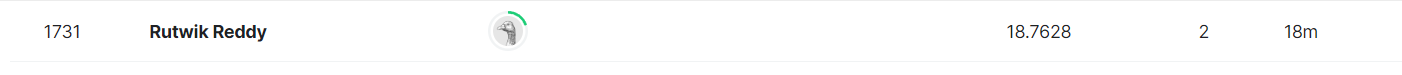
